In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from itertools import cycle
import pickle
import sys
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential

%matplotlib inline

In [ ]:
data = pd.read_csv('/results/dataset/balanced100k_2018.csv',header=0)


<ipython-input-8-a529efcf6720>:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/network/balanced100k_2018.csv',header=0)


In [ ]:
data['Label'].value_counts()

,count
Label,
DDoS attacks-LOIC-HTTP,100000
Bot,100000
Infilteration,99999
Benign,99997
DoS attacks-Hulk,85898
SSH-Bruteforce,74921
FTP-BruteForce,25079
DoS attacks-GoldenEye,8064
DoS attacks-SlowHTTPTest,4056


In [ ]:
data

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Flow ID,Src IP,Src Port,Dst IP
0,80,6,20/02/2018 10:33:40,1172999,3,4,20.0,964.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,DDoS attacks-LOIC-HTTP,172.31.69.25-52.14.136.135-80-60344-6,52.14.136.135,60344.0,172.31.69.25
1,52302,6,20/02/2018 01:29:08,2378,3,1,31.0,0.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Benign,172.31.65.6-23.36.33.160-52302-443-6,23.36.33.160,443.0,172.31.65.6
2,80,6,16/02/2018 01:46:10,9021,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,DoS attacks-Hulk,NaN,NaN,NaN,NaN
3,443,6,20/02/2018 03:32:39,59834166,9,15,548.0,9245.0,183.0,0.0,...,86331.0,19844513.333333,9559292.589311,25480312.0,8807222.0,Benign,152.195.32.112-172.31.66.19-443-51217-6,172.31.66.19,51217.0,152.195.32.112
4,8080,6,02/03/2018 02:15:12,10819,3,4,326.0,129.0,326.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Bot,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599992,8080,6,02/03/2018 02:26:40,10952,3,4,326.0,129.0,326.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Bot,NaN,NaN,NaN,NaN
599993,8080,6,02/03/2018 12:06:49,499,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Bot,NaN,NaN,NaN,NaN
599994,443,6,20/02/2018 12:36:32,77952,2,1,74.0,126.0,74.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Benign,172.31.69.12-13.89.188.5-49672-443-6,172.31.69.12,49672.0,13.89.188.5
599995,8080,6,02/03/2018 11:18:17,13578,3,4,326.0,129.0,326.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Bot,NaN,NaN,NaN,NaN


In [ ]:

# Orijinal sütun adlarını al (gerçek header satırı)
numeric_columns = data.columns.difference(['Label'])  # örnek hariç tutulanlar

df_cleaned = data[
    data[numeric_columns].applymap(lambda x: isinstance(x, (int, float)) or pd.api.types.is_numeric_dtype(type(x))).all(axis=1)
]


<ipython-input-6-27ca68a23635>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[numeric_columns].applymap(lambda x: isinstance(x, (int, float)) or pd.api.types.is_numeric_dtype(type(x))).all(axis=1)


In [ ]:
data

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Flow ID,Src IP,Src Port,Dst IP
0,80,6,20/02/2018 10:33:40,1172999,3,4,20.0,964.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,DDoS attacks-LOIC-HTTP,172.31.69.25-52.14.136.135-80-60344-6,52.14.136.135,60344.0,172.31.69.25
1,52302,6,20/02/2018 01:29:08,2378,3,1,31.0,0.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Benign,172.31.65.6-23.36.33.160-52302-443-6,23.36.33.160,443.0,172.31.65.6
2,80,6,16/02/2018 01:46:10,9021,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,DoS attacks-Hulk,NaN,NaN,NaN,NaN
3,443,6,20/02/2018 03:32:39,59834166,9,15,548.0,9245.0,183.0,0.0,...,86331.0,19844513.333333,9559292.589311,25480312.0,8807222.0,Benign,152.195.32.112-172.31.66.19-443-51217-6,172.31.66.19,51217.0,152.195.32.112
4,8080,6,02/03/2018 02:15:12,10819,3,4,326.0,129.0,326.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Bot,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599992,8080,6,02/03/2018 02:26:40,10952,3,4,326.0,129.0,326.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Bot,NaN,NaN,NaN,NaN
599993,8080,6,02/03/2018 12:06:49,499,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Bot,NaN,NaN,NaN,NaN
599994,443,6,20/02/2018 12:36:32,77952,2,1,74.0,126.0,74.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Benign,172.31.69.12-13.89.188.5-49672-443-6,172.31.69.12,49672.0,13.89.188.5
599995,8080,6,02/03/2018 11:18:17,13578,3,4,326.0,129.0,326.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Bot,NaN,NaN,NaN,NaN


In [ ]:
print(data.columns.tolist())

['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd By

In [ ]:
y = data['Label']
X = data.drop(labels=['Label', 'Flow ID', 'Source IP', 'Source Port',
              'Destination IP', 'Destination Port', 'Protocol', 'Timestamp'], axis=1)

In [ ]:
y = data['Label']
X = data.drop(labels=['Label', 'Flow ID', 'Src IP', 'Src Port',
              'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'], axis=1)

In [ ]:
X

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,1172999,3,4,20.0,964.0,20.0,0.0,6.666667,11.547005,964.0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2378,3,1,31.0,0.0,31.0,0.0,10.333333,17.897858,0.0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9021,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59834166,9,15,548.0,9245.0,183.0,0.0,60.888889,91.33379,1460.0,...,2,20,100208.666667,16720.383498,118772.0,86331.0,19844513.333333,9559292.589311,25480312.0,8807222.0
4,10819,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,112.0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599992,10952,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,112.0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599993,499,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599994,77952,2,1,74.0,126.0,74.0,0.0,37.0,52.325902,126.0,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599995,13578,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,112.0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X.isnull().values.any()



np.False_

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()


In [ ]:
y.isnull().values.any()


np.False_

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Activation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Activation

In [7]:
model = Sequential()
model.add(Conv1D(64, kernel_size=3, padding='same', input_shape=(76, 1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'num_classes' is not defined

In [6]:
batch_size = 64
model = Sequential()
model.add(Convolution1D(64, kernel_size=32, padding="same",
          activation="relu", input_shape=(76, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape=(128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

NameError: name 'X_train' is not defined

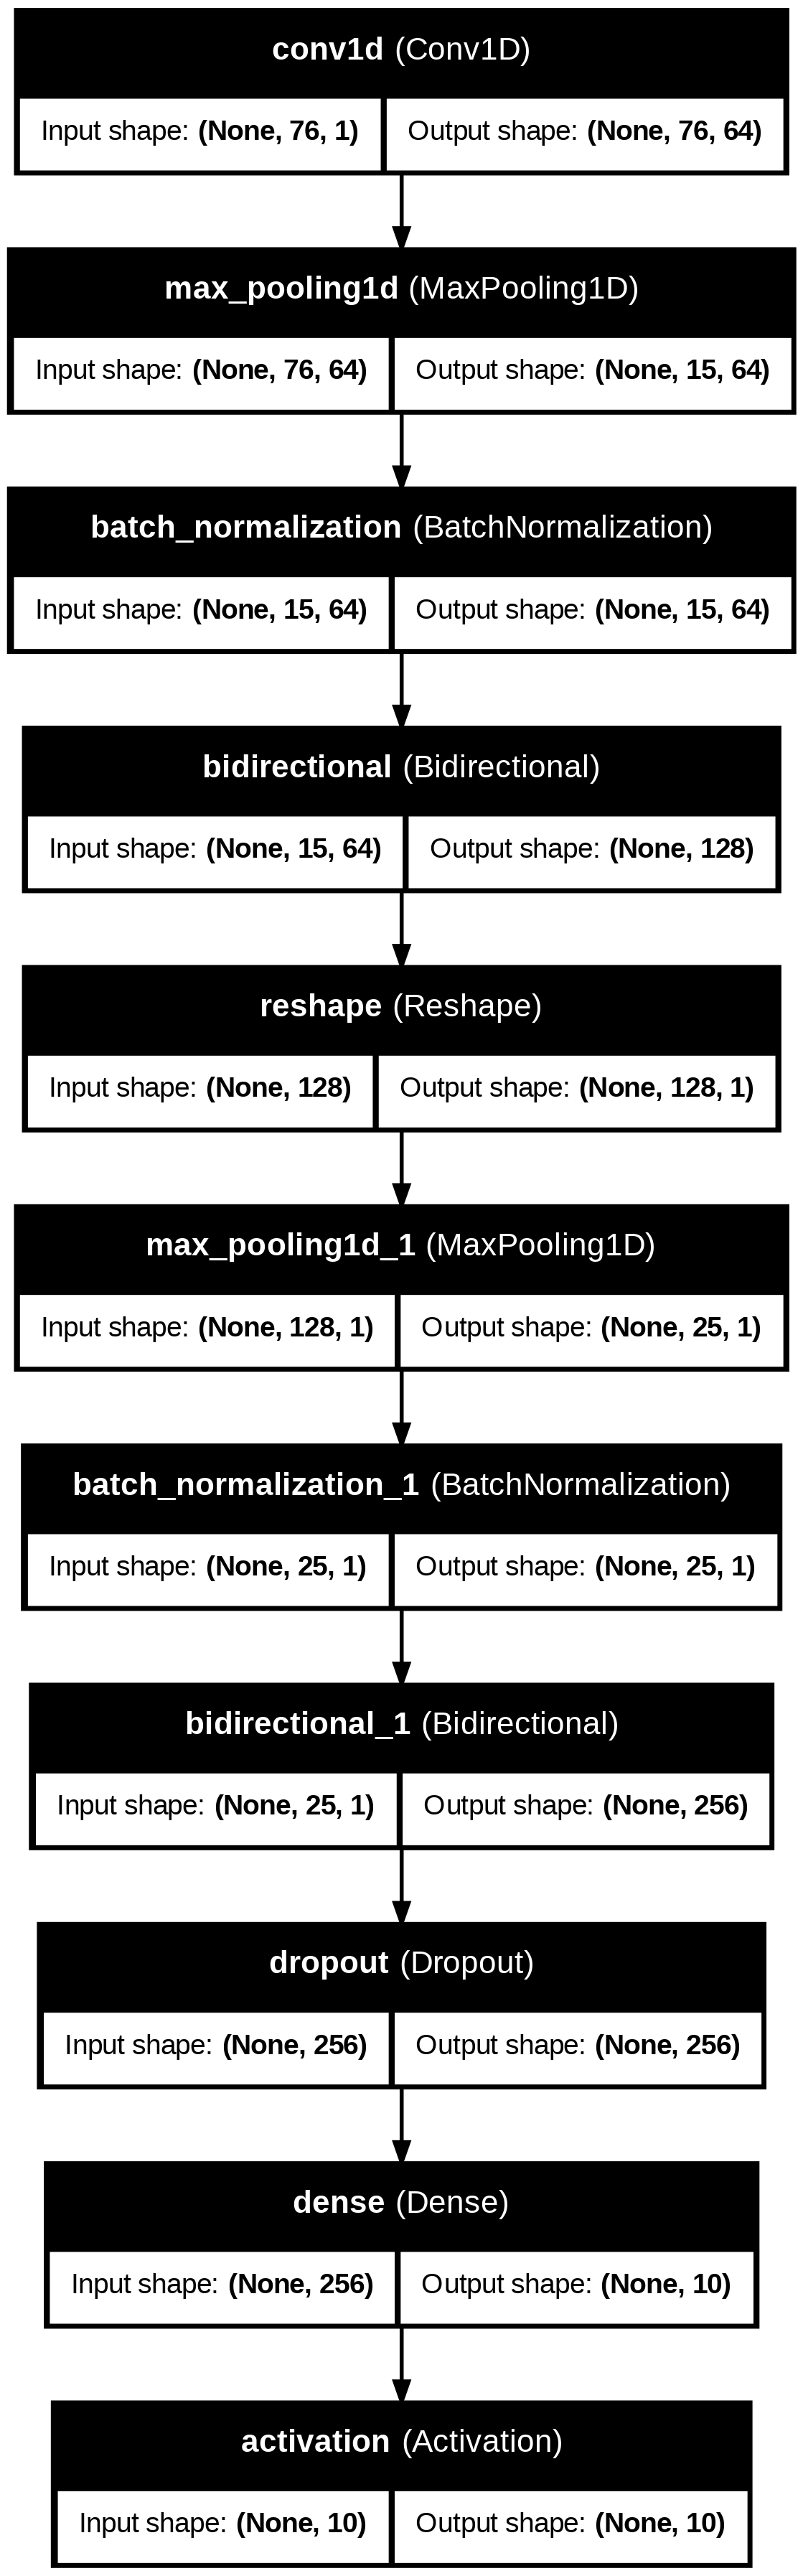

In [3]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='/content/model.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.summary(line_length=100)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                          │ (None, 76, 64)                  │             2,112 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling1d_2 (MaxPooling1D)             │ (None, 15, 64)                  │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_2 (BatchNormalization) │ (None, 15, 64)                  │               256 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bidirectional_2 (Bidirectional)            │ (None, 128)                     │            66,048 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ reshape_1 (Reshape)                        │ (None, 128, 1)                  │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling1d_3 (MaxPooling1D)             │ (None, 25, 1)                   │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_3 (BatchNormalization) │ (None, 25, 1)                   │                 4 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bidirectional_3 (Bidirectional)            │ (None, 256)                     │           133,120 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_1 (Dropout)                        │ (None, 256)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_1 (Dense)                            │ (None, 10)                      │             2,570 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_1 (Activation)                  │ (None, 10)                      │                 0 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 204,110 (797.30 KB)

 Trainable params: 203,980 (796.80 KB)

 Non-trainable params: 130 (520.00 B)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
scores = pd.DataFrame(columns=[1, 2, 3, 4, 5, 'Mean'],
                      index=['Accuracy', 'Precision', 'Recall', 'F1'])

In [ ]:
def print_metrics(y_eval: np.ndarray, y_pred: np.ndarray, average: str = 'binary') -> List[float]:
    accuracy = metrics.accuracy_score(y_eval, y_pred)
    precision = metrics.precision_score(y_eval, y_pred, average=average)
    recall = metrics.recall_score(y_eval, y_pred, average=average)
    f1 = metrics.f1_score(y_eval, y_pred, average=average)

    print('Accuracy =', accuracy)
    print('Precision =', precision)
    print('Recall =', recall)
    print('F1 =', f1)

    return [accuracy, precision, recall, f1]

In [ ]:
actual_targets = np.empty([0], dtype=float)
predicted_targets = np.empty([0], dtype=float)

In [ ]:
def train_and_validate(model: Sequential,
                       X: pd.DataFrame,
                       y: pd.Series,
                       train_index: np.ndarray,
                       test_index: np.ndarray,
                       scaler: sklearn.preprocessing.MinMaxScaler) -> Tuple[np.ndarray, np.ndarray]:
    # Get the train/test splits
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y[train_index].copy(), y[test_index].copy()

    print("Train index:", train_index)
    print("Test index:", test_index)

    # Remove any rows with "Flow Duration" as string — just in case
    X_train = X_train[X_train['Flow Duration'] != 'Flow Duration']
    X_test = X_test[X_test['Flow Duration'] != 'Flow Duration']

    # Convert all columns to numeric if needed (safe fallback)
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    X_test = X_test.apply(pd.to_numeric, errors='coerce')

    # Remove rows with NaN or infinite values
    X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna()
    X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna()

    # Align y_train and y_test with cleaned X
    y_train = y_train.loc[X_train.index]
    y_test = y_test.loc[X_test.index]

    # Feature scaling
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape for CNN/RNN input
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # One-hot encode target
    y_train_encoded = pd.get_dummies(y_train).values
    y_test_encoded = pd.get_dummies(y_test).values

    # Train the model
    model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=10)

    # Predict
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_eval = np.argmax(y_test_encoded, axis=1)

    return y_eval, y_pred


In [ ]:
# Tensorflow 1.14.

# This option may be used to speed up the CPU computation in some cases.
# import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'

# Configure session parameters for the optimal parallelization and choose the computational device (CPU, GPU or both).
# config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=48,
#                                   inter_op_parallelism_threads=48, allow_soft_placement=True, device_count={'CPU': 24})
# with tf.compat.v1.Session(config=config) as sess:

# Tensorflow 2.X, the computation is performed on CPU.
# with tf.device('/CPU:0'):

# Tensorflow 2.X, the computation is performed on GPU.
# with tf.device('/GPU:0'):

    # Set a timer for the learning time evaluation.
    start_time = time.time()

    i = 1
    # Stratified K-Folds cross-validation.
    for train_index, test_index in cv.split(X, y):
        y_eval, y_pred = train_and_validate(
            model, X, y, train_index, test_index, scaler)
        # Store test and predicted labels.
        actual_targets = np.append(actual_targets, y_eval)
        predicted_targets = np.append(predicted_targets, y_pred)
        # Get and print validation scores.
        print("Validation scores:")
        scores[i] = print_metrics(y_eval, y_pred, average='weighted')
        i += 1

    # Get the learning time.
    print('Total operation time: ', time.time() - start_time, 'seconds')

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Train index: [     0      2      4 ... 599994 599995 599996]
Test index: [     1      3      6 ... 599978 599983 599984]
Epoch 1/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 190s 12ms/step - accuracy: 0.8195 - loss: 0.3923 - val_accuracy: 0.8549 - val_loss: 0.2707
Epoch 2/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.8648 - loss: 0.2423 - val_accuracy: 0.8704 - val_loss: 0.2217
Epoch 3/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.8692 - loss: 0.2291 - val_accuracy: 0.8731 - val_loss: 0.2209
Epoch 4/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 185s 12ms/step - accuracy: 0.8725 - loss: 0.2261 - val_accuracy: 0.8750 - val_loss: 0.2184
Epoch 5/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 185s 12ms/step - accuracy: 0.8723 - loss: 0.2221 - val_accuracy: 0.8736 - val_loss: 0.2156
Epoch 6/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 185s 12ms/step - accuracy: 0.8747 - loss: 0.2156 - val_accuracy: 0.8785 - val_loss: 0.2098
Epoch 7/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 185s 12ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train index: [     0      1      2 ... 599992 599995 599996]
Test index: [     7     16     17 ... 599990 599993 599994]
Epoch 1/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.8773 - loss: 0.2085 - val_accuracy: 0.8785 - val_loss: 0.2064
Epoch 2/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.8778 - loss: 0.2076 - val_accuracy: 0.8778 - val_loss: 0.2075
Epoch 3/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.8778 - loss: 0.2084 - val_accuracy: 0.8769 - val_loss: 0.2060
Epoch 4/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.8775 - loss: 0.2084 - val_accuracy: 0.8757 - val_loss: 0.2103
Epoch 5/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.8772 - loss: 0.2086 - val_accuracy: 0.8791 - val_loss: 0.2073
Epoch 6/10
14986/14986 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.8786 - loss: 0.2071 - val_accuracy: 0.8791 - val_loss: 0.2039
Epoch 7/10
 7370/14986 ━━━━━━━━━━━━━━━━━━━━ 1:25 11ms/step - accuracy

KeyboardInterrupt: 

In [ ]:
class_counts = y.value_counts()
print(class_counts[class_counts < 2])  # See which classes cause the issue

# Optionally drop those rare classes
valid_classes = class_counts[class_counts >= 2].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

Label
Label    1
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
# Create index-based split for compatibility with train_and_validate
train_index, test_index = train_test_split(
    np.arange(len(X)), test_size=0.2, random_state=42, stratify=y
)

actual_targets = np.empty([0], dtype=float)
predicted_targets = np.empty([0], dtype=float)
scores = {}

with tf.device('/GPU:0'):
    start_time = time.time()

    # Perform training and validation
    y_eval, y_pred = train_and_validate(model, X, y, train_index, test_index, scaler)

    actual_targets = np.append(actual_targets, y_eval)
    predicted_targets = np.append(predicted_targets, y_pred)

    print("Validation scores:")
    scores[1] = print_metrics(y_eval, y_pred, average='weighted')

    print('Total operation time: ', time.time() - start_time, 'seconds')


Train index: [469447 504720 273858 ... 184712   4381 564625]
Test index: [475924  42343 321920 ... 124797  15612 564343]
Epoch 1/10
14985/14985 ━━━━━━━━━━━━━━━━━━━━ 238s 16ms/step - accuracy: 0.8779 - loss: 0.2067 - val_accuracy: 0.8803 - val_loss: 0.2031
Epoch 2/10
14985/14985 ━━━━━━━━━━━━━━━━━━━━ 236s 16ms/step - accuracy: 0.8788 - loss: 0.2064 - val_accuracy: 0.8803 - val_loss: 0.2023
Epoch 3/10
14985/14985 ━━━━━━━━━━━━━━━━━━━━ 236s 16ms/step - accuracy: 0.8796 - loss: 0.2048 - val_accuracy: 0.8790 - val_loss: 0.2048
Epoch 4/10
14985/14985 ━━━━━━━━━━━━━━━━━━━━ 236s 16ms/step - accuracy: 0.8791 - loss: 0.2058 - val_accuracy: 0.8793 - val_loss: 0.2051
Epoch 5/10
14985/14985 ━━━━━━━━━━━━━━━━━━━━ 236s 16ms/step - accuracy: 0.8795 - loss: 0.2050 - val_accuracy: 0.8761 - val_loss: 0.2091
Epoch 6/10
14985/14985 ━━━━━━━━━━━━━━━━━━━━ 234s 16ms/step - accuracy: 0.8790 - loss: 0.2057 - val_accuracy: 0.8785 - val_loss: 0.2040
Epoch 7/10
14985/14985 ━━━━━━━━━━━━━━━━━━━━ 237s 16ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
scores['Mean'] = scores.mean(axis=1)
scores

AttributeError: 'dict' object has no attribute 'mean'

In [ ]:
model.save("/results/2018_100k_balanced_model_scaled.keras")

In [ ]:
df['Label'].value_counts()


,count
Label,
BENIGN,5087
Web Attack – Brute Force,1507
Web Attack – XSS,652
Web Attack – Sql Injection,21


In [ ]:
from keras.models import load_model

model = load_model("/content/drive/MyDrive/network/2018_100k_balanced_model_scaled.keras")